In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
def check_thk(top,botm):
    """
    check if all the cells in a modflow model (given top and botm array) which have a thickness <= 0 for and this for each layer
    input : top (the top surface) and botm (botom of each layer)
    output : lst of bool (false mean everything's okay in that specific layer !)
    """
    nlay = botm.shape[0]
    bol_lst=[]
    bol_lst.append(not ((top-botm[0])<=0).any())
    for ilay in range(nlay-1):
        bol_lst.append(not ((botm[ilay]-botm[ilay+1])<=0).any())
    return bol_lst

def array2cellids(array, idomain):

    """
    Convert an array to a list of cellids
    array : 3D array, array to convert
    idomain : 3D array, idomain array which determine if a cell is active or not (1 active, 0 inactive)
    """
    cellids = []

    idomain_copy = idomain.copy()
    idomain_copy[idomain == -1] = 0
    b = array & idomain_copy.astype(bool)
    for ilay in range(b.shape[0]):
        for irow in range(b.shape[1]):
            for icol in range(b.shape[2]):
                if b[ilay, irow, icol]:
                    cellids.append((ilay, irow, icol))
    return cellids

In [3]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 140
ny = 70
nz = 70
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [4]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential", {"w":.21,"r":[50, 50, 10]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B1 = gcm.CovModel3D(elem=[("exponential", {"w":.16,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B2 = gcm.CovModel3D(elem=[("exponential", {"w":.24,"r":[100, 100, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B3 = gcm.CovModel3D(elem=[("exponential", {"w":.19,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B4 = gcm.CovModel3D(elem=[("exponential", {"w":.13,"r":[100, 100, 4]})], alpha=0, name="vario_SIS") # input variogram

lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelB=[covmodel_SIS_B1, covmodel_SIS_B2, covmodel_SIS_B3, covmodel_SIS_B4] # list of covmodels to pass


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6.5}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":lst_covmodelC, "probability":[0.3, 0.7]}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-8.5}
dic_f_B = {"f_method":"SIS", "neig" : 10, "f_covmodel":lst_covmodelB, "probability":[0.2, 0.4, 0.25, 0.15]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-11}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [5]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_3, facies_5])
D.add_facies([facies_1])
C.add_facies([facies_4, facies_6])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2]
means = [-4, -2, -6, -9, -6, -7, -19]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = list_covmodels,
                                means = means,
                                int_method = "sgs",
                                vmin = -10,
                                vmax = -1
                                )



Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Facies Sand added to unit D
Facies Clay added to unit C
Facies Silt added to unit C


In [6]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [7]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop(prop_model)

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added


In [8]:
T1.compute_surf(3)
T1.compute_facies(2)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order
Discrepency in the orders for units A and B
Changing orders for that they range from 1 to n

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.04456663131713867 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.04961061477661133 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.03182196617126465 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.08079743385314941 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.032553911209106445 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.02602362632751465 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0277707576751709 s

#### COMPUTING SURFACE OF 

In [9]:
import flopy as fp

In [10]:
pv.set_jupyter_backend("client")

In [11]:
T1.plot_units()

Widget(value='<iframe src="http://localhost:61484/index.html?ui=P_0x1a55026ece0_0&reconnect=auto" class="pyvis…

In [12]:
T1.plot_facies()

Widget(value='<iframe src="http://localhost:61484/index.html?ui=P_0x1a55026ebf0_1&reconnect=auto" class="pyvis…

In [13]:
T1.plot_prop("K")

Widget(value='<iframe src="http://localhost:61484/index.html?ui=P_0x1a55022aa10_2&reconnect=auto" class="pyvis…

In [14]:
val = T1.get_prop("K")[0, 0, 0]
im = geone.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=x0, oy=y0, oz=z0, nv=1, val=val)

In [15]:

factor_x = 4
factor_y = 2
factor_z = 2

nlay, nrow, ncol = T1.get_nz(), T1.get_ny(), T1.get_nx()
delr, delc = T1.get_sx(), T1.get_sy()
xoff, yoff = T1.get_ox(), T1.get_oy()

assert factor_x is not None, "factor_x must be provided"
assert factor_y is not None, "factor_y must be provided"
assert factor_z is not None, "factor_z must be provided"
assert nrow % factor_y == 0, "nrow must be divisible by factor_y"
assert ncol % factor_x == 0, "ncol must be divisible by factor_x"
assert nlay % factor_z == 0, "nlay must be divisible by factor_z"
nrow = int(nrow / factor_y)
ncol = int(ncol / factor_x)
nlay = int(nlay / factor_z)
delr = delr * factor_x
delc = delc * factor_y
top = np.ones((nrow, ncol)) * T1.get_zg()[-1]
botm = np.ones((nlay, nrow, ncol)) * T1.get_zg()[::-factor_z][1:].reshape(-1, 1, 1)
botm = np.flip(np.flipud(botm), axis=1)  # flip the array to have the same orientation as the ArchPy table
botm.shape

(35, 35, 35)

In [16]:
delc, delr

(3.0, 6.0)

In [132]:
# create a class to handle the conversion instead of a function
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nx * ny + i * nx + j)
    return nodes

class archpy2modflow:

    """
    Class to convert an ArchPy table to a MODFLOW 6 model

    Parameters
    ----------
    T1 : Arch_table
        ArchPy table to convert
    sim_name : str
        name of the simulation
    model_dir : str
        directory where the model will be saved
    model_name : str
        name of the model
    exe_name : str
        path to the mf6 executable
    """

    def __init__(self, T1, sim_name="sim_test", model_dir="workspace", model_name="test", exe_name="mf6"):
        self.T1 = T1
        self.sim_name = sim_name
        self.model_dir = model_dir
        self.model_name = model_name
        self.exe_name = exe_name
        self.sim = None
        self.grid_mode = None
        self.layers_names = None
        self.list_active_cells = None
        self.mp = None
        self.factor_x = None
        self.factor_y = None
        self.factor_z = None

    def create_sim(self, grid_mode="archpy", iu=0, factor_x=None, factor_y=None, factor_z=None):

        """
        Create a modflow simulation from an ArchPy table
        
        Parameters
        ----------
        grid_mode : str
            "archpy" : use the grid defined in the ArchPy table
            "layers" : use the surfaces of each unit to define the grid
            "new_resolution" : use factors to change the resolution of the grid
            In this case, factor_x, factor_y and factor_z must be provided
        iu : int
            index of the unit to use when grid_mode is "layers"
        factor_x : float
            factor to change the resolution of the grid in the x direction. e.g. 2 means that the resolution will be divided by 2
        factor_y : float
            factor to change the resolution of the grid in the y direction.
        factor_z : float    
            factor to change the resolution of the grid in the z direction.
        """

        sim = fp.mf6.MFSimulation(sim_name=self.sim_name, version='mf6', exe_name=self.exe_name, 
                         sim_ws=self.model_dir)
        gwf = fp.mf6.ModflowGwf(sim, modelname=self.model_name,
                                model_nam_file='{}.nam'.format(self.model_name))

        #grid
        nlay, nrow, ncol = self.T1.get_nz(), self.T1.get_ny(), self.T1.get_nx()
        delr, delc = self.T1.get_sx(), self.T1.get_sy()
        xoff, yoff = self.T1.get_ox(), self.T1.get_oy()

        if grid_mode == "archpy":
            top = np.ones((nrow, ncol)) * self.T1.get_zg()[-1]
            botm = np.ones((nlay, nrow, ncol)) * self.T1.get_zg()[:-1].reshape(-1, 1, 1)
            botm = np.flip(np.flipud(botm), axis=1)  # flip the array to have the same orientation as the ArchPy table
            idomain = np.flip(np.flipud(self.T1.get_mask().astype(int)), axis=1)  # flip the array to have the same orientation as the ArchPy table

        elif grid_mode == "layers":
            # get surfaces of each unit
            top = T1.get_surface(typ="top")[0][0, iu]
            top = np.flip(top, axis=1)
            botm = T1.get_surface(typ="bot")[0][:, iu]
            botm = np.flip(botm, axis=1)
            layers_names = T1.get_surface(typ="bot")[1]
            self.layers_names = layers_names
            nlay = botm.shape[0]

            # define idomain (1 if thickness > 0, 0 if nan, -1 if thickness = 0)
            idomain = np.ones((nlay, nrow, ncol))
            thicknesses = -np.diff(np.vstack([top.reshape(-1, nrow, ncol), botm]), axis=0)
            idomain[thicknesses == 0] = -1
            idomain[np.isnan(thicknesses)] = 0

            # adapt botm in order that each layer has a thickness > 0 
            for i in range(-1, nlay-1):
                if i == -1:
                    s1 = top
                else:
                    s1 = botm[i]
                s2 = botm[i+1]
                mask = s1 == s2
                s1[mask] += 1e-2

        elif grid_mode == "new_resolution":
            assert factor_x is not None, "factor_x must be provided"
            assert factor_y is not None, "factor_y must be provided"
            assert factor_z is not None, "factor_z must be provided"
            assert nrow % factor_y == 0, "nrow must be divisible by factor_y"
            assert ncol % factor_x == 0, "ncol must be divisible by factor_x"
            assert nlay % factor_z == 0, "nlay must be divisible by factor_z"
            nrow = int(nrow / factor_y)
            ncol = int(ncol / factor_x)
            nlay = int(nlay / factor_z)
            delr = delr * factor_x
            delc = delc * factor_y
            top = np.ones((nrow, ncol)) * self.T1.get_zg()[-1]
            botm = np.ones((nlay, nrow, ncol)) * self.T1.get_zg()[::-factor_z][1:].reshape(-1, 1, 1)
            # botm = np.flip(np.flipud(botm), axis=1)  # flip the array to have the same orientation as the ArchPy table
            
            # how to define idomain ?
            idomain = np.zeros((nlay, nrow, ncol))
            mask_org = self.T1.get_mask().astype(int)
            for ilay in range(0, self.T1.get_nz(), factor_z):
                for irow in range(0, self.T1.get_ny(), factor_y):
                    for icol in range(0, self.T1.get_nx(), factor_x):
                        mask = mask_org[ilay:ilay+factor_z, irow:irow+factor_y, icol:icol+factor_x]
                        if mask.mean() >= 0.5:
                            idomain[ilay//factor_z, irow//factor_y, icol//factor_x] = 1
            
            self.factor_x = factor_x
            self.factor_y = factor_y
            self.factor_z = factor_z
            
        else:
            raise ValueError("grid_mode must be one of 'archpy', 'layers' or 'new_resolution'")

        # save grid mode
        self.grid_mode = grid_mode
        
        assert (np.array(check_thk(top, botm))).all(), "Error in the processing of the surfaces, some cells have a thickness < 0"

        dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                    delr=delr, delc=delc,
                                    top=top, botm=botm,
                                    xorigin=xoff, yorigin=yoff, 
                                    idomain=idomain)

        perioddata = [(1, 1, 1.0)]
        tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=perioddata)

        ims = fp.mf6.ModflowIms(sim, complexity="simple")

        #Initial condition
        ic   = fp.mf6.ModflowGwfic(gwf, strt=1)

        # output control
        oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(self.model_name),
                                    head_filerecord='{}.hds'.format(self.model_name),
                                    saverecord=[('HEAD', 'LAST'),
                                                ('BUDGET', 'LAST')],
                                    printrecord=[('BUDGET', 'ALL')])
        
        # npf package
        # empty package
        npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=1, save_flows=True)

        self.sim = sim
        print("Simulation created")
        print("To retrieve the simulation, use the get_sim() method")
    
    def set_k(self, k_key="K",
              iu=0, ifa=0, ip=0,
              log=False, k=None, k22=None, k33=None, k_average_method="arithmetic", 
              upscaling_method="simplified_renormalization"):

        """
        Set the hydraulic conductivity for a specific facies
        """

        # write a function to get proportion of each value in the array
        def get_proportion(arr):
            unique, counts = np.unique(arr, return_counts=True)
            return dict(zip(unique, counts/np.sum(counts)))

        # remove the npf package if it already exists
        gwf = self.get_gwf()
        gwf.remove_package("npf")

        if k is None:
            grid_mode = self.grid_mode
            if grid_mode == "archpy":
                new_k22 = None
                new_k33 = None
                k = self.T1.get_prop(k_key)[iu, ifa, ip]
                k = np.flip(np.flipud(k), axis=1)  # flip the array to have the same orientation as the ArchPy table
                if log:
                    new_k = 10**k
                else:
                    new_k = k

            elif grid_mode == "layers":

                new_k22 = None
                nrow, ncol, nlay = gwf.modelgrid.nrow, gwf.modelgrid.ncol, gwf.modelgrid.nlay

                # initialize new_k and new_k33
                kh = self.T1.get_prop(k_key)[iu, ifa, ip] 
                new_k = np.ones((nlay, nrow, ncol))

                # initialize variable for facies upscaling
                facies_arr = self.T1.get_facies(iu, ifa, all_data=False)
                upscaled_facies = {}

                for ifa in np.unique(facies_arr):
                    upscaled_facies[ifa] = np.zeros((facies_arr.shape[0], facies_arr.shape[1], facies_arr.shape[2]))

                if k_average_method == "anisotropic":
                    new_k33 = np.ones((nlay, nrow, ncol))
                else:
                    new_k33 = None
                layers = self.layers_names
                mask_units = [self.T1.unit_mask(l).astype(bool) for l in layers]

                for irow in range(nrow):
                    for icol in range(ncol):
                        for ilay in range(nlay):
                            mask_unit = mask_units[ilay]
                            if k_average_method == "arithmetic":
                                new_k[ilay, irow, icol] = np.mean(kh[:, irow, icol][mask_unit[:, irow, icol]])
                            elif k_average_method == "harmonic":
                                new_k[ilay, irow, icol] = 1 / np.mean(1 / kh[:, irow, icol][mask_unit[:, irow, icol]])
                            elif k_average_method == "anisotropic":
                                new_k[ilay, irow, icol] = np.mean(kh[:, irow, icol][mask_unit[:, irow, icol]])
                                new_k33[ilay, irow, icol] = 1 / np.mean(1 / kh[:, irow, icol][mask_unit[:, irow, icol]])
                            else:
                                raise ValueError("k_average_method must be one of 'arithmetic' or 'harmonic'")
                            
                            # facies upscaling
                            arr = facies_arr[:, irow, icol][mask_unit[:, irow, icol]]  # array of facies values in the unit
                            prop = get_proportion(arr)
                            for ifa in np.unique(arr):
                                upscaled_facies[ifa][:, irow, icol][mask_unit[:, irow, icol]] = prop[ifa]
                
                # save upscaled facies
                self.upscaled_facies = upscaled_facies

                # fill nan values with the mean of the layer
                for ilay in range(nlay):
                    mask = np.isnan(new_k[ilay])
                    new_k[ilay][mask] = np.nanmean(new_k[ilay])

                new_k = np.flip(new_k, axis=1)  # we have to flip in order to match modflow grid

                if k_average_method == "anisotropic":
                    for ilay in range(nlay):
                        mask = np.isnan(new_k33[ilay])
                        new_k33[ilay][mask] = np.nanmean(new_k33[ilay])
                    
                    new_k33 = np.flip(new_k33, axis=1)

                if log:
                    new_k = 10**new_k
                    if k_average_method == "anisotropic":
                        new_k33 = 10**new_k33

            elif grid_mode == "new_resolution":

                from uppy import upscale_k
                dx, dy, dz = self.T1.get_sx(), self.T1.get_sy(), self.T1.get_sz()
                
                factor_x = self.factor_x
                factor_y = self.factor_y
                factor_z = self.factor_z
                
                field = self.T1.get_prop(k_key)[iu, ifa, ip]
                field = np.flip(np.flipud(field), axis=1)  # flip the array to have the same orientation as the ArchPy table
                
                if upscaling_method == "standard_renormalization_center":
                    field_kxx, field_kyy, field_kzz = upscale_k(field, method="standard_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="center")
                elif upscaling_method == "standard_renormalization_direct":
                    field_kxx, field_kyy, field_kzz = upscale_k(field, method="standard_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="direct")
                elif upscaling_method == "tensorial_renormalization":
                    field_kxx, field_kyy, field_kzz = upscale_k(field, method="tensorial_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
                elif upscaling_method == "simplified_renormalization":
                    field_kxx, field_kyy, field_kzz = upscale_k(field, method="simplified_renormalization", dx=dx, dy=dy, dz=dz, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
                
                new_k = field_kxx
                new_k22 = field_kyy
                new_k33 = field_kzz
                
                # fill nan values
                new_k[np.isnan(new_k)] = np.nanmean(new_k)
                new_k22[np.isnan(new_k22)] = np.nanmean(new_k22)
                new_k33[np.isnan(new_k33)] = np.nanmean(new_k33)

                if log:
                    new_k = 10**new_k
                    new_k22 = 10**new_k22
                    new_k33 = 10**new_k33

                # facies upscaling
                facies_arr = self.T1.get_facies(iu, ifa, all_data=False)
                upscaled_facies = {}
                for ifa in np.unique(facies_arr):
                    upscaled_facies[ifa] = np.zeros((facies_arr.shape[0], facies_arr.shape[1], facies_arr.shape[2]))
                
                for ilay in range(0, self.T1.get_nz(), factor_z):
                    for irow in range(0, self.T1.get_ny(), factor_y):
                        for icol in range(0, self.T1.get_nx(), factor_x):
                            mask_unit = facies_arr[ilay:ilay+factor_z, irow:irow+factor_y, icol:icol+factor_x]
                            arr = mask_unit.flatten()
                            prop = get_proportion(arr)
                            for ifa in np.unique(arr):
                                upscaled_facies[ifa][ilay:ilay+factor_z, irow:irow+factor_y, icol:icol+factor_x] = prop[ifa]

                self.upscaled_facies = upscaled_facies
        else:
            new_k = k
            new_k22 = k22
            new_k33 = k33

        # new_k = np.flip(new_k, axis=1)  # we have to flip in order to match modflow grid
        npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=new_k, k22=new_k22, k33=new_k33, save_flows=True, save_specific_discharge=True)
        npf.write()


    def set_strt(self, heads=None):
        """
        Set the starting heads
        """
        gwf = self.get_gwf()
        gwf.remove_package("ic")
        ic = fp.mf6.ModflowGwfic(gwf, strt=heads)
        ic.write()

    def get_list_active_cells(self):

        if self.list_active_cells is None:
            gwf = self.get_gwf()
            idomain = gwf.dis.idomain.array
            list_active_cells = []
            for ilay in range(idomain.shape[0]):
                for irow in range(idomain.shape[1]):
                    for icol in range(idomain.shape[2]):
                        if idomain[ilay, irow, icol] == 1:
                            list_active_cells.append((ilay, irow, icol))
            self.list_active_cells = list_active_cells
            
        return self.list_active_cells

    # get functions
    def get_sim(self):
        assert self.sim is not None, "You need to create the simulation first"
        return self.sim
    
    def get_gwf(self):
        assert self.sim is not None, "You need to create the simulation first"
        return self.sim.get_model()

    # outputs
    def get_heads(self, kstpkper=(0, 0)):
        """
        Get the heads of the simulation
        """
        gwf = self.get_gwf()
        head = gwf.output.head().get_data(kstpkper=kstpkper)
        return head
    
    # plots
    def plot_3D_heads(self, kstpkper=(0, 0), ax=None, **kwargs):

        """
        Plot the heads of the simulation
        """
        assert self.grid_mode == "archpy", "This function only works with the 'archpy' grid mode"
        
        head = self.get_heads(kstpkper=kstpkper)
        head[head == 1e30] = np.nan

        T1.plot_arr(np.flipud(np.flip(head, axis=1)), "head", 2)

    def mp_create(self, mpexe, trackdir="forward",
                  locs=None, rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
                  list_p_coord=None):
        """
        Create a modpath simulation from an ArchPy table

        Parameters
        ----------
        mpexe : str
            path to the modpath executable
        trackdir : str
            direction of tracking
        locs : list of tuples
            list of cells to put particles. List of int where values correspond to the indices of the cells.
            Each cell in locs will be then spatially divided and will output rowcelldivisions * columncelldivisions * layercelldivisions particles
        rowcelldivisions : int
            number of row divisions. If 1, no division, if 2, divide each cell in 2 parts, etc.
        columncelldivisions : int
            number of column divisions
        layercelldivisions : int
            number of layer divisions
        list_p_coord : list of tuples
            list of particles coordinates. Each tuple must have 3 values (xp, yp, zp) corresponding to the coordinates of the particle
        """

        gwf = self.get_gwf()
        workspace = self.model_dir
        model_name = gwf.name
        mpnamf = f"{model_name}_mp_forward"
        
        if locs is not None:
            nodes = get_nodes(locs)
            if len(nodes) == 0:
                print("No particles to track")
                return
            elif len(nodes) == 1:
                nodes = nodes[0]
            mp = fp.modpath.Modpath7.create_mp7(
                                                modelname=mpnamf,
                                                trackdir=trackdir,
                                                flowmodel=gwf,
                                                model_ws=workspace,
                                                rowcelldivisions=rowcelldivisions,
                                                columncelldivisions=columncelldivisions,
                                                layercelldivisions=layercelldivisions,
                                                nodes = nodes,
                                                exe_name=mpexe,
                                            )
        else:
            if list_p_coord is not None:
                # write a function to find the modlfow cellids as well as localx, localy and localz from a coordinate
                from shapely.geometry import Point, MultiPoint

                grid = self.get_gwf().modelgrid
                ix = fp.utils.gridintersect.GridIntersect(mfgrid=grid)

                list_p = []
                list_cellids = []
                for pi in list_p_coord:
                    p1 = Point(pi)
                    list_cellids.append(ix.intersect(p1).cellids[0])

                cellids = np.array([cids for cids in list_cellids])

                # multp = MultiPoint(list_p)

                # cellids = ix.intersect(multp).cellids
                # cellids = np.array([np.array(cids) for cids in cellids])
                cellids[:, 0] += 1

                l = []
                for i in range(len(cellids)):
                    cid = cellids[i]
                    exem_i = list_p_coord[i]
            
                    local_dx = (grid.xvertices[cid[1], cid[2]+1] - grid.xvertices[cid[1], cid[2]]) / 2
                    local_dy = - (grid.yvertices[cid[1]+1, cid[2]] - grid.yvertices[cid[1], cid[2]]) / 2
                    # local_dz = - (grid.zcellcenters[cid[0]+1, cid[1], cid[2]] - grid.zcellcenters[cid[0], cid[1], cid[2]]) / 2
                    local_dz = (grid.botm[cid[0]-1, cid[1], cid[2]] - grid.botm[cid[0], cid[1], cid[2]]) / 2
                    localx = (exem_i[0] - (grid.xcellcenters[cid[1], cid[2]] - local_dx)) / (2*local_dx)
                    localy = (exem_i[1] - (grid.ycellcenters[cid[1], cid[2]] - local_dy)) / (2*local_dy)
                    localz = (exem_i[2] - (grid.zcellcenters[cid[0], cid[1], cid[2]] - local_dz)) / (2*local_dz)

                    p1 = fp.modpath.mp7particledata.ParticleData([tuple(cid)], structured=True, localx=localx, localy=localy, localz=localz)
                    pg = fp.modpath.mp7particlegroup.ParticleGroup(particledata=p1)

                    l.append(pg)
                    
                # create a modpath simulation
                mp = fp.modpath.Modpath7(
                    modelname=mpnamf,
                    flowmodel=gwf,
                    exe_name=mpexe,
                    model_ws=workspace,
                    verbose=0,
                )

                # basic package
                fp.modpath.Modpath7Bas(mp)

                fp.modpath.Modpath7Sim(
                    mp,
                    simulationtype="combined",
                    trackingdirection=trackdir,
                    weaksinkoption="pass_through",
                    weaksourceoption="pass_through",
                    referencetime=0.0,
                    stoptimeoption="extend",
                    particlegroups=l,
                )

        self.mp = mp  # save the modpath object
        self.mpnamf = mpnamf  # save the name of the modpath file

    def set_porosity(self, 
                     iu = 0, ifa = 0, ip = 0, 
                     porosity=None, k_key="porosity"):

        """
        Set the porosity of the model

        Parameters
        ----------
        iu : int
            unit simulation index
        ifa : int
            facies simulation index
        ip : int
            property simulation index
        porosity : float
            porosity value, if None, the porosity is taken from the table according to the k_key
        k_key : str
            key of the property in the table
        """
        
        gwf = self.get_gwf()
        if porosity is None:
            
            # check if the porosity is already in the table
            assert k_key in self.T1.get_prop_names(), "The property {} is not in the table".format(k_key)

            grid_mode = self.grid_mode
            if grid_mode == "archpy":

                k = self.T1.get_prop(k_key)[iu, ifa, ip]
                k = np.flip(np.flipud(k), axis=1)  # flip the array to have the same orientation as the ArchPy table
                new_k = k

            elif grid_mode == "layers":

                nrow, ncol, nlay = gwf.modelgrid.nrow, gwf.modelgrid.ncol, gwf.modelgrid.nlay

                kh = self.T1.get_prop(k_key)[iu, ifa, ip] 
                new_k = np.ones((nlay, nrow, ncol))

                layers = self.layers_names
                mask_units = [self.T1.unit_mask(l).astype(bool) for l in layers]

                for irow in range(nrow):
                    for icol in range(ncol):
                        for ilay in range(nlay):
                            mask_unit = mask_units[ilay]
                            new_k[ilay, irow, icol] = np.mean(kh[:, irow, icol][mask_unit[:, irow, icol]])

                # fill nan values with the mean of the layer
                for ilay in range(nlay):
                    mask = np.isnan(new_k[ilay])
                    new_k[ilay][mask] = np.nanmean(new_k[ilay])

                new_k = np.flip(new_k, axis=1)  # we have to flip in order to match modflow grid

            elif grid_mode == "new_resolution":
                pass
            
        else:
            new_k = porosity

        mpbas = fp.modpath.Modpath7Bas(self.get_mp(), porosity=new_k)


    def mp_run(self, silent=False):
        self.mp.write_input()
        success, msg = self.mp.run_model(silent=silent)
        if not success:
            print("modpath did not run successfully")
            print(msg)

    def get_mp(self):
        return self.mp
    
    def mp_get_pathlines_object(self):

        fpth = os.path.join(self.model_dir, f"{self.mpnamf}.mppth")
        p = fp.utils.PathlineFile(fpth)
        return p


    def mp_get_endpoints_object(self):

        fpth = os.path.join(self.model_dir, f"{self.mpnamf}.mpend")
        e = fp.utils.EndpointFile(fpth)
        return e

In [161]:
def get_df_particle(archpy_flow, i_particle, fac_time = 1/86400):

    grid_mode = archpy_flow.grid_mode
    p = archpy_flow.mp_get_pathlines_object()
    pathline = p.get_data(i_particle)
    df = pd.DataFrame(pathline)
    cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int),
                            ((df["y"].values-T1.yg[0])//T1.sy).astype(int),
                            ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T
    

    time_ordered = df["time"].values.copy()
    time_ordered *= fac_time
    dt = np.diff(time_ordered)

    # add a column to track distance traveled
    df["distance"] = 0
    for i in range(1, df.shape[0]):
        x0, y0, z0 = df[["x", "y", "z"]].iloc[i-1]
        x1, y1, z1 = df[["x", "y", "z"]].iloc[i]
        distance = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
        df.loc[df.index[i], "distance"] = distance

    df["cum_distance"] = df["distance"].cumsum()

    # store everything in a new dataframe
    df_all = pd.DataFrame(columns=["dt", "time", "distance", "cum_distance", "x", "y", "z"])
    df_all["dt"] = dt
    df_all["time"] = time_ordered[:-1]
    df_all["distance"] = df["distance"].values[:-1]
    df_all["cum_distance"] = df["cum_distance"].values[:-1]
    df_all["x"] = df["x"].values[:-1]
    df_all["y"] = df["y"].values[:-1]
    df_all["z"] = df["z"].values[:-1]

    if grid_mode in ["layers", "new_resolution"]:
        dic_facies_path = {}
        # retrieve lithologies along the pathlines
        for fa in archpy_flow.T1.get_all_facies():
            id_fa = fa.ID
            prop_fa = archpy_flow.upscaled_facies[id_fa]

            facies_along_path = prop_fa[cells_path[:, 0], cells_path[:, 1], cells_path[:, 2]]
            dic_facies_path[fa.ID] = facies_along_path
        colors_fa = []
        for k, v in dic_facies_path.items():
            df_all["facies_prop_"+ str(k)] = v[:-1]
            colors_fa.append(archpy_flow.T1.get_facies_obj(ID=k, type="ID").c)

    elif grid_mode == "archpy":
        facies = archpy_flow.T1.get_facies(iu, ifa, all_data=False)
        facies_along_path = facies[cells_path[:, 0], cells_path[:, 1], cells_path[:, 2]]
        df_all["facies"] = facies_along_path[:-1]

    else:
        raise ValueError
    return df_all


## archpy2modflow

Here is a simple example of how to use the `archpy2modflow` package to convert an ArchPy model to a MODFLOW model using the `flopy` package.
Several modes can be used to convert the ArchPy model to a MODFLOW model. The modes are:
- `archpy` mode: This mode uses the ArchPy model to create a MODFLOW model. The ArchPy model is used to create the MODFLOW model grid, boundary conditions, and initial conditions.
- `layers` mode: This mode considers that each stratigraphic unit is a modflow layer and uses the surfaces simulated by ArchPy to define the bottom elevation of each layer. K values are averaged between the top and bottom of each layer.
- `new_resolution` mode: upscaled model

### archpy mode

In [47]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="archpy", iu=0)
archpy_flow.set_k("K", 0, 0, 0, log=True)

Simulation created
To retrieve the simulation, use the get_sim() method


In [48]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [18]:
def cellidBD(idomain, layer=0):   
    
    """
    extract the cellids at the boundary of the domain at a given layer
    idomain : 3D array, idomain array which determine if a cell is active or not (1 active, 0 inactive)
    layer : int, layer on which the boundary cells are extract
    """
    lst_cellBD=[]

    for irow in range(idomain.shape[1]):
        for icol in range(idomain.shape[2]):
            if idomain[layer][irow,icol]==1:
                #check neighbours
                if np.sum(idomain[layer][irow-1:irow+2,icol-1:icol+2]==1) < 8:
                    lst_cellBD.append((layer,irow,icol))
    return lst_cellBD

In [144]:
# add BC at left and right on all layers

h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [145]:
# archpy_flow.set_k("K", 0, 0, 0, k = np.ones((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol))*2e-3)
archpy_flow.set_k(k_key = "K", 
                  iu=0, ifa=0, ip=0, 
                  log=True)

In [146]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 8400 based on size of stress_period_data
    writing package npf...


In [147]:
sim.ims.complexity = "complex"
# sim.ims.outer_maximum = 10
# sim.ims.outer_dvclose = 0.5
# sim.ims.under_relaxation ="NONE"
# sim.ims.linear_acceleration = "BICGSTAB"
sim.ims.write()

In [148]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Governm

(True, [])

In [149]:
# heads = archpy_flow.get_heads()
# archpy_flow.set_strt(heads=heads)

In [150]:
# archpy_flow.set_k(k_key = "K", 
#                   iu=0, ifa=0, ip=0, 
#                   log=True)

In [151]:
# sim.run_simulation()

In [152]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

In [153]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

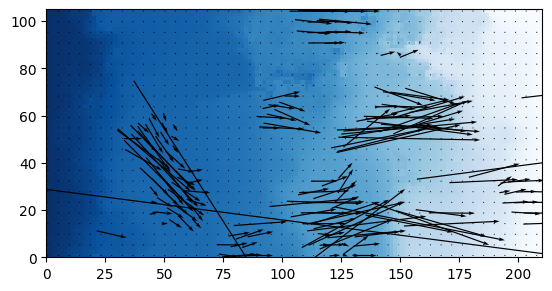

In [154]:
from flopy.plot import PlotMapView
mapview = PlotMapView(model=gwf, layer=15)
quadmesh = mapview.plot_array(heads, cmap="Blues")
# quadmesh = mapview.contour_array(heads, cmap="jet", levels=10)
# quadmesh = mapview.plot_array(np.log10(gwf.npf.k.array), cmap="viridis")
mapview.plot_vector(qx, qy, color="black", istep=3, jstep=3)

In [155]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

T1.plot_arr(np.flipud(np.flip(heads, axis=1)), "head", 2)

Widget(value='<iframe src="http://localhost:55575/index.html?ui=P_0x1d4d020ee60_8&reconnect=auto" class="pyvis…

In [156]:
T1.plot_prop("K", v_ex=2)

Widget(value='<iframe src="http://localhost:55575/index.html?ui=P_0x1d4c55ee290_9&reconnect=auto" class="pyvis…

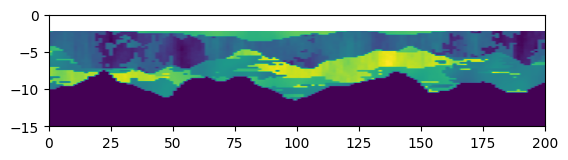

In [162]:
plt.imshow(np.fliplr(T1.get_prop("K")[0, 0, 0, :, -1, :]), aspect=3, origin="lower", extent=[0, 200, -15, 0])

In [158]:
# mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coord=[(70.7, 99.75, -7), (70.7, 99.75, -9), (70.7, 99.75, -11)])

In [159]:
archpy_flow.mp_run(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Switchdrive\Post_doc\prog\exe\modflow_exe\win64\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                  

In [160]:
p = archpy_flow.mp_get_pathlines_object()

<Figure size 1000x1000 with 0 Axes>

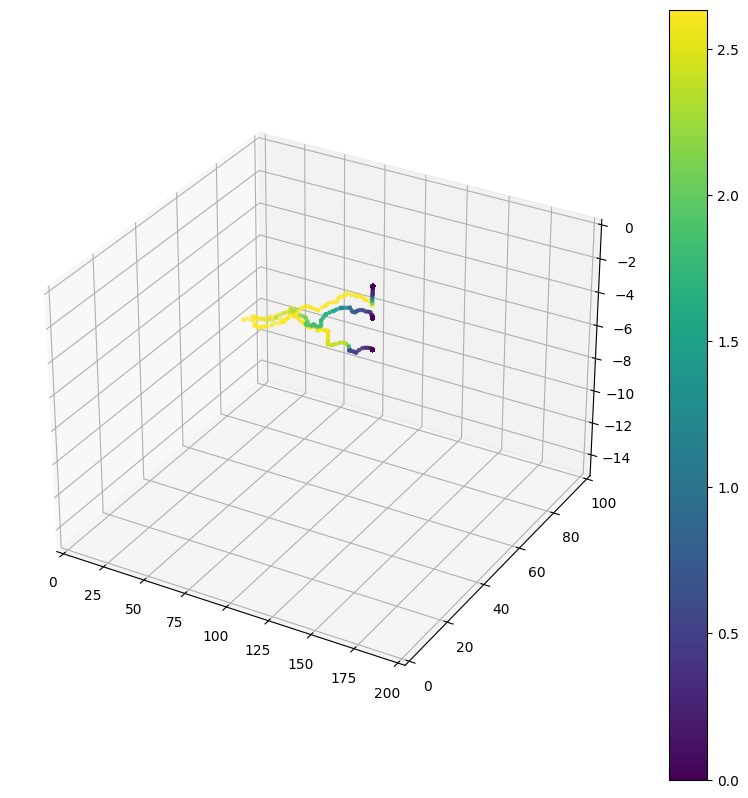

In [167]:
fig = plt.figure(figsize=(10, 10))
path = p.get_alldata()

# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[0:40]:
    # ax.plot(pth["x"], pth["y"], pth["z"])
    g = ax.scatter(pth["x"], pth["y"], pth["z"], s=5, c=pth["time"]/86400, cmap="viridis")
plt.colorbar(g)
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
plt.show()

In [192]:
T1.plot_facies(inside_units=[C], v_ex=1, excludedVal=[])

Widget(value='<iframe src="http://localhost:55575/index.html?ui=P_0x1d4b4f22b60_18&reconnect=auto" class="pyvi…

In [175]:
print(p.get_alldata()[0][["x", "y", "z"]][0], p.get_alldata()[1][["x", "y", "z"]][0], p.get_alldata()[2][["x", "y", "z"]][0])

(70.7, 99.75, -7.) (70.7, 99.75, -9.) (70.7, 99.75, -11.)


In [176]:
import pandas as pd

In [181]:
df = pd.DataFrame(p.get_alldata()[0])
cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int), ((df["y"].values-T1.yg[0])//T1.sy).astype(int), ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T

In [182]:
pd.to_timedelta(df["time"], unit="s")

0               0 days 00:00:00
1        0 days 00:00:00.010000
2        0 days 00:00:00.020000
3     0 days 00:00:00.029999999
4     0 days 00:00:00.039999999
                 ...           
198           273 days 05:27:52
199           273 days 05:29:16
200           273 days 05:30:34
201           273 days 05:30:42
202           273 days 05:30:42
Name: time, Length: 203, dtype: timedelta64[ns]

In [183]:
# keep unique cells in the path but keep the order
unique_cells = np.unique(cells_path, axis=0)
_, idx = np.unique(cells_path, axis=0, return_index=True)
unique_cells_ordered = cells_path
time_ordered = df["time"].values
time_ordered /= 86400
df = df

In [184]:
df

,particleid,particlegroup,sequencenumber,particleidloc,time,x,y,z,k,node,xloc,yloc,zloc,stressperiod,timestep
0,0,0,0,0,0.000000e+00,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1
1,0,0,0,0,1.157407e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1
2,0,0,0,0,2.314815e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1
3,0,0,0,0,3.472222e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1
4,0,0,0,0,4.629630e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0,0,0,0,2.732277e+02,4.500000,88.401649,-9.798084,35,344543,0.000000,0.934433,0.679529,1,1
199,0,0,0,0,2.732287e+02,3.000000,88.369949,-9.816708,35,344542,0.000000,0.913298,0.555368,1,1
200,0,0,0,0,2.732296e+02,1.615089,88.136742,-9.900013,35,344541,0.076726,0.757828,0.000000,1,1
201,0,0,0,0,2.732296e+02,1.500000,88.116570,-9.909690,36,354340,1.000000,0.744379,0.935485,1,1


In [185]:
# add a column to track distance traveled
df["distance"] = 0
for i in range(1, df.shape[0]):
    x0, y0, z0 = df[["x", "y", "z"]].iloc[i-1]
    x1, y1, z1 = df[["x", "y", "z"]].iloc[i]
    distance = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
    df.loc[df.index[i], "distance"] = distance

df["cum_distance"] = df["distance"].cumsum()

In [186]:
df

,particleid,particlegroup,sequencenumber,particleidloc,time,x,y,z,k,node,xloc,yloc,zloc,stressperiod,timestep,distance,cum_distance
0,0,0,0,0,0.000000e+00,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1,0.000000,0.000000
1,0,0,0,0,1.157407e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1,0.000000,0.000000
2,0,0,0,0,2.314815e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1,0.000000,0.000000
3,0,0,0,0,3.472222e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1,0.000000,0.000000
4,0,0,0,0,4.629630e-07,70.699997,99.750000,-7.000000,16,157267,0.133333,0.500000,0.333469,1,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0,0,0,0,2.732277e+02,4.500000,88.401649,-9.798084,35,344543,0.000000,0.934433,0.679529,1,1,1.506875,84.171714
199,0,0,0,0,2.732287e+02,3.000000,88.369949,-9.816708,35,344542,0.000000,0.913298,0.555368,1,1,1.500451,85.672164
200,0,0,0,0,2.732296e+02,1.615089,88.136742,-9.900013,35,344541,0.076726,0.757828,0.000000,1,1,1.406878,87.079042
201,0,0,0,0,2.732296e+02,1.500000,88.116570,-9.909690,36,354340,1.000000,0.744379,0.935485,1,1,0.117243,87.196285


In [187]:
# retrieve lithologies along the pathlines
facies_domains = T1.get_facies(0, 0, all_data = False)
facies_along_path = facies_domains[unique_cells_ordered[:, 0], unique_cells_ordered[:, 1], unique_cells_ordered[:, 2]]

In [188]:
facies_along_path

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2], dtype=int8)

In [189]:
dt = np.diff(time_ordered)
dt

array([1.15740740e-07, 1.15740740e-07, 1.15740747e-07, 1.15740733e-07,
       1.15740733e-07, 1.15740761e-07, 1.15740761e-07, 1.15740704e-07,
       1.15740761e-07, 1.15740704e-07, 1.15740704e-07, 1.15740818e-07,
       1.15740704e-07, 1.15740818e-07, 1.15740704e-07, 1.15740704e-07,
       1.15740818e-07, 1.15740704e-07, 1.15740704e-07, 1.15740704e-07,
       1.15740704e-07, 1.15740704e-07, 1.15740932e-07, 1.15740704e-07,
       1.15740704e-07, 1.15740704e-07, 1.15740932e-07, 1.15740704e-07,
       1.15740477e-07, 1.15740932e-07, 1.15740704e-07, 1.15740704e-07,
       1.15740704e-07, 1.15740932e-07, 1.15740477e-07, 1.15740932e-07,
       1.15740932e-07, 1.15740477e-07, 1.15740477e-07, 1.15740932e-07,
       1.15740932e-07, 1.15740477e-07, 1.15740932e-07, 1.15740477e-07,
       1.15740932e-07, 1.15740932e-07, 1.15740477e-07, 1.15740932e-07,
       1.15740932e-07, 1.15740477e-07, 1.15740477e-07, 1.15740932e-07,
       1.15740477e-07, 1.15741386e-07, 1.15740477e-07, 1.15740932e-07,
      

[]

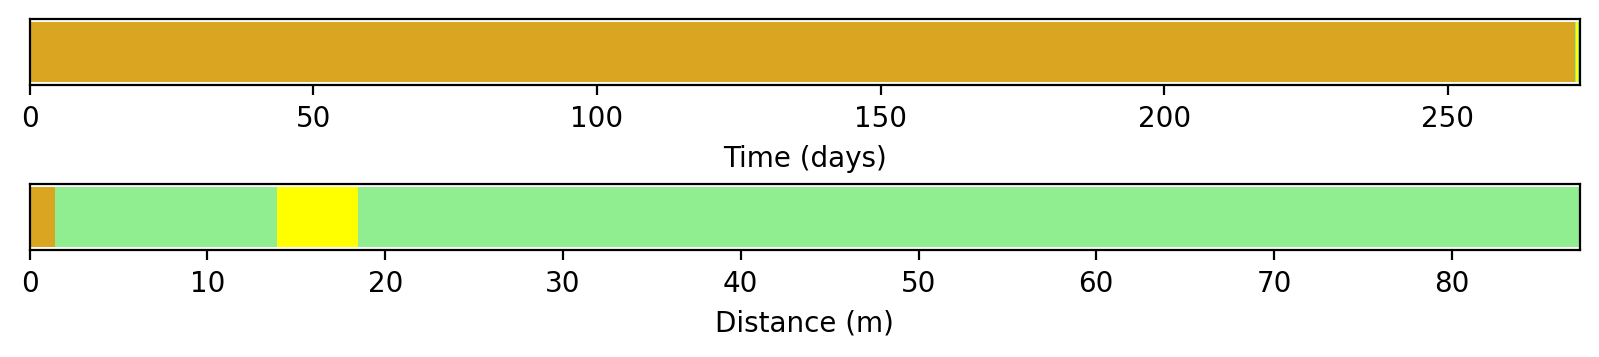

In [190]:
%matplotlib inline
# plot facies along the pathlines as a horizontal bar plot where each color corresponds to a facies
fig, ax = plt.subplots(2,1, figsize=(10, 1.5), dpi=200)
plt.subplots_adjust(hspace=1.5)

for i, (facies, time) in enumerate(zip(facies_along_path, time_ordered)):

    if i >= len(dt):
        break
    ax[0].barh(0, dt[i], left=time, color=T1.get_facies_obj(ID=facies, type="ID").c)


ax[0].set_xlim(0, time_ordered[-1])
ax[0].set_xlabel("Time (days)")
ax[0].set_yticks([])

# plot facies function of the distance traveled
all_dist = df["distance"].values
all_cum_dist = df["cum_distance"].values

for i in range(int(len(facies_along_path) - 1)):
    facies = facies_along_path[i]
    width = all_dist[i+1]
    distance = all_cum_dist[i]
    ax[1].barh(0, width, left=distance, color=T1.get_facies_obj(ID=facies, type="ID").c)


ax[1].set_xlim(0, all_cum_dist[-1])
ax[1].set_xlabel("Distance (m)")
ax[1].set_yticks([])
    

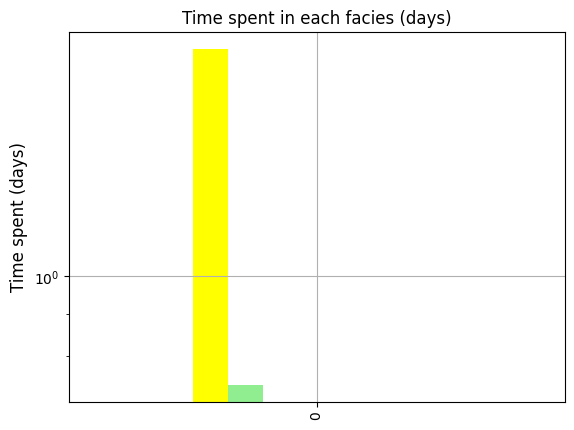

In [79]:
fig, ax = plt.subplots()

df_time = pd.DataFrame(columns=[fa.name for fa in list_facies])
# initialize the time spent in each facies
time_spent = np.zeros(len(list_facies))
for i, fa in enumerate(list_facies):
    time_spent[i] = 0
df_time.loc[0] = time_spent

for i in range(len(time_ordered)-1):
    dt = time_ordered[i+1] - time_ordered[i]
    for j, fa in enumerate(list_facies):
        if facies_along_path[i] == fa.ID:
            time_spent[j] += dt

color_facies = [fa.c for fa in list_facies]

df_time.plot(kind="bar", color=color_facies, legend=False, logy=True, ax=ax)
ax.set_title("Time spent in each facies (days)")
ax.set_ylabel("Time spent (days)", fontsize=12)
plt.grid()
plt.show()

In [ ]:
l_df = []
for iu in range(3):
    for ifa in range(2):
        # set hydraulic cond
        archpy_flow.set_k(k_key = "K", 
                        iu=iu, ifa=ifa, ip=0, 
                        log=True)

        # run simulation
        sim.run_simulation()

        # setup modpath
        mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
        archpy_flow.mp_create(mpexe=mpexe_path, 
                            trackdir="backward", 
                            list_p_coord=[(70.7, 99.75, -10)])
        archpy_flow.mp_run(silent=False)

        p = archpy_flow.mp_get_pathlines_object()
        df = pd.DataFrame(p.get_alldata()[0])
        cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int), ((df["y"].values-T1.yg[0])//T1.sy).astype(int), ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T

        unique_cells_ordered = cells_path
        time_ordered = df["time"].values
        time_ordered /= 86400

        # add a column to track distance traveled
        df["distance"] = 0
        for i in range(1, df.shape[0]):
            x0, y0, z0 = df[["x", "y", "z"]].iloc[i-1]
            x1, y1, z1 = df[["x", "y", "z"]].iloc[i]
            distance = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
            df.loc[df.index[i], "distance"] = distance

        df["cum_distance"] = df["distance"].cumsum()


        # retrieve lithologies along the pathlines
        facies_domains = T1.get_facies(iu, ifa, all_data = False)
        facies_along_path = facies_domains[unique_cells_ordered[:, 0], unique_cells_ordered[:, 1], unique_cells_ordered[:, 2]]

        dt = np.diff(time_ordered)

        # store everything in a new dataframe
        df_all = pd.DataFrame(columns=["dt", "time", "distance", "cum_distance", "facies"])
        df_all["dt"] = dt
        df_all["time"] = time_ordered[:-1]
        df_all["distance"] = df["distance"].values[:-1]
        df_all["cum_distance"] = df["cum_distance"].values[:-1]
        df_all["facies"] = facies_along_path[:-1]

        l_df.append(df_all)

FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Governm

In [137]:
def plot_particle_tracking(arch_table, df, plot_time=False, plot_distance=False):

    if plot_time and plot_distance:
        fig, ax = plt.subplots(2,1, figsize=(10, 1.5), dpi=200)
        axi = ax[0]
    elif plot_time or plot_distance:
        fig, axi = plt.subplots(1,1, figsize=(10, 0.5), dpi=200)
    plt.subplots_adjust(hspace=1.5)


    if plot_time:
        dt = df["dt"]
        for i, (facies, time) in enumerate(zip(df["facies"], df["time"])):
            
            axi.barh(0, dt[i], left=time, color=arch_table.get_facies_obj(ID=facies, type="ID").c)
        
        axi.set_xlim(0, df["time"].iloc[-1])
        axi.set_xlabel("Time (days)")
        axi.set_yticks([])

        if plot_distance:
            axi = ax[1]
    
    if plot_distance:

        # plot facies function of the distance traveled
        all_dist = df["distance"].values
        all_cum_dist = df["cum_distance"].values

        for i in range(int(len(df["facies"]) - 1)):
            facies = df["facies"].iloc[i]
            width = all_dist[i+1]
            distance = all_cum_dist[i]
            axi.barh(0, width, left=distance, color=arch_table.get_facies_obj(ID=facies, type="ID").c)

        axi.set_xlim(0, all_cum_dist[-1])
        axi.set_xlabel("Distance (m)")
        axi.set_yticks([])


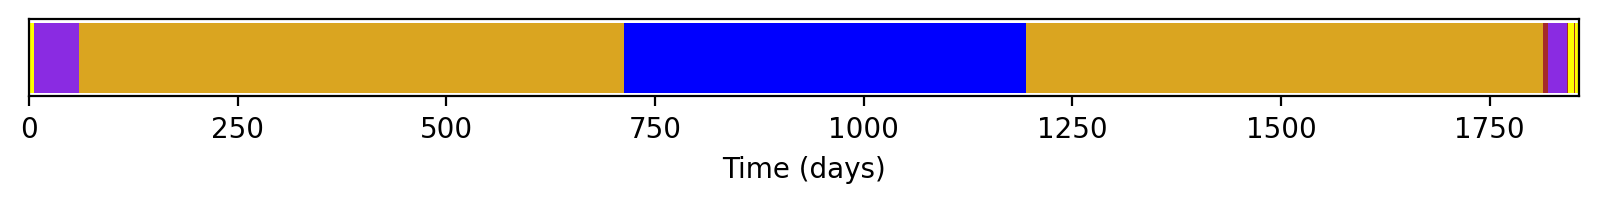

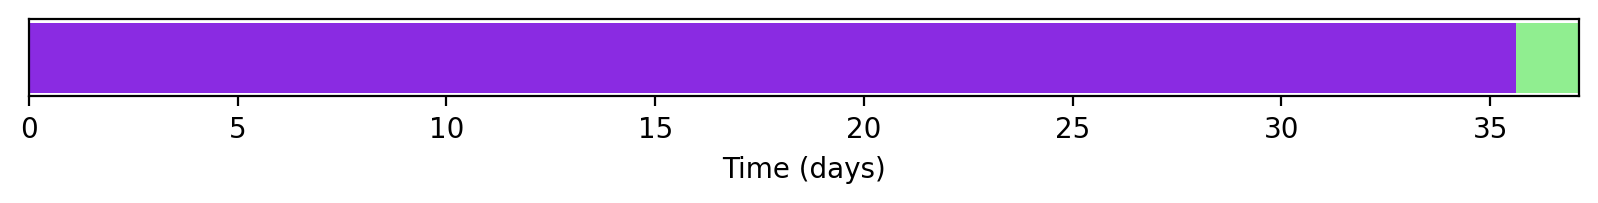

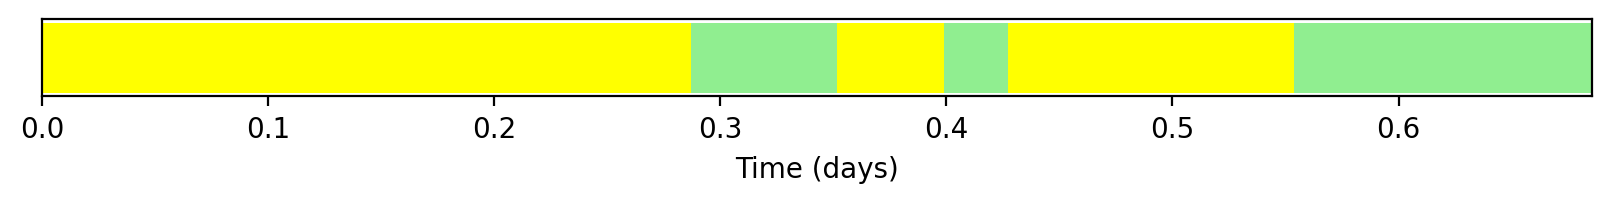

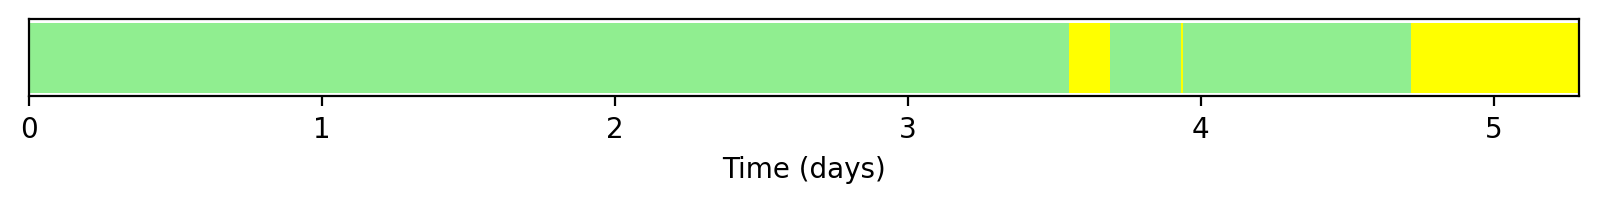

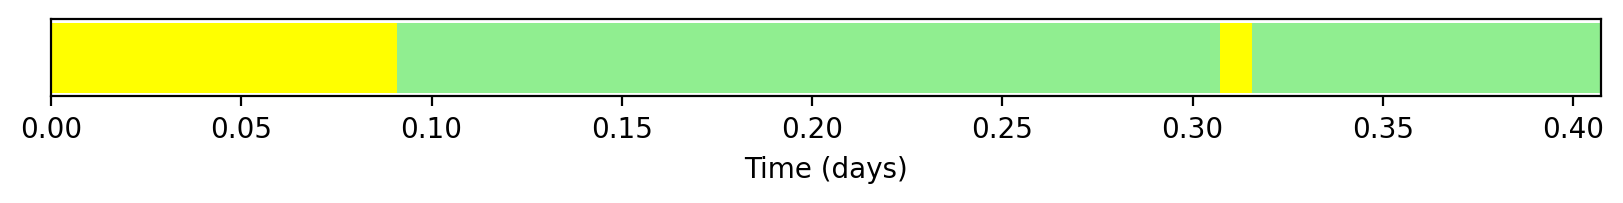

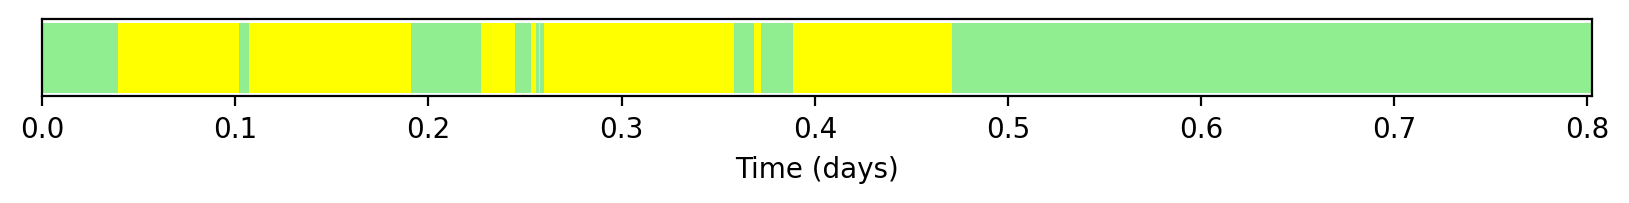

In [109]:
for i in range(6):
    plot_particle_tracking(T1, l_df[i], plot_time=True)

### Layers mode

In [80]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="layers", iu=0)
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")

Simulation created
To retrieve the simulation, use the get_sim() method


In [81]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [82]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)
    

In [83]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 536 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subje

(True, [])

In [84]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

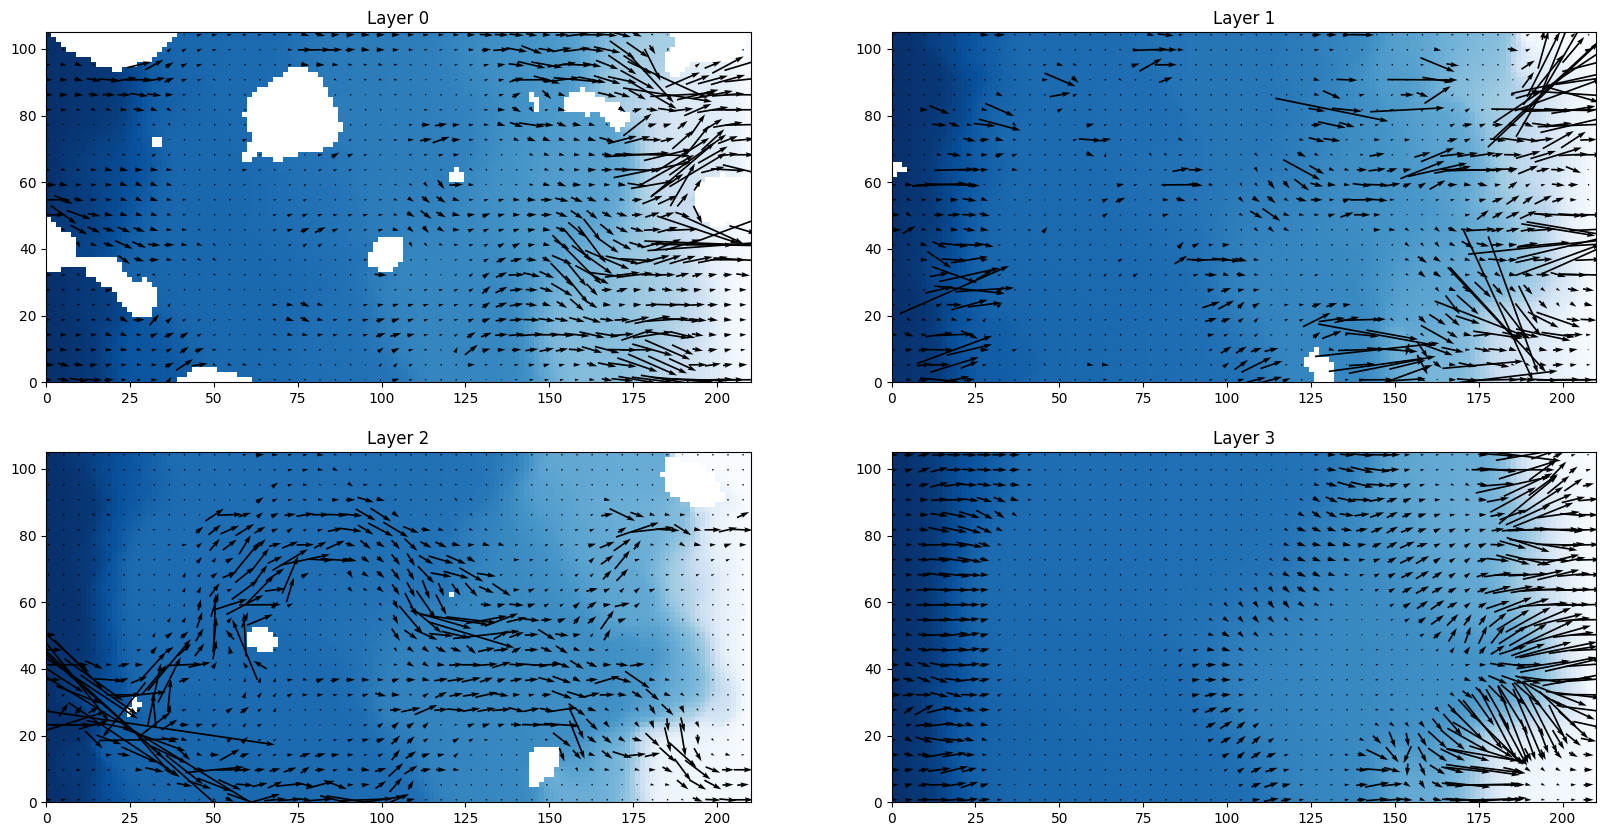

In [85]:
# plots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
axes = ax.flatten()
from flopy.plot import PlotMapView
for ilayer in range(gwf.modelgrid.nlay):
    mapview = PlotMapView(model=gwf, layer=ilayer, ax=axes[ilayer])
    quadmesh = mapview.plot_array(heads[ilayer], cmap="Blues")
    mapview.plot_vector(qx[ilayer], qy[ilayer], color="black", istep=3, jstep=3)
    axes[ilayer].set_title("Layer {}".format(ilayer))

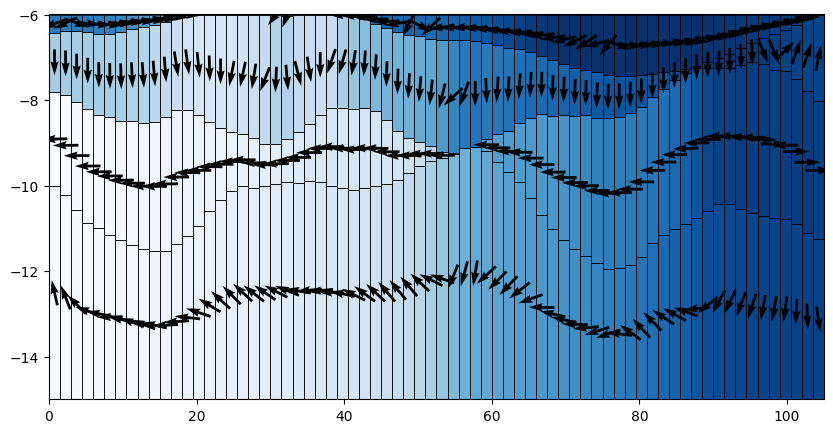

In [86]:
# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"column": 40})
cross_section.plot_array(heads, cmap="Blues", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True)
cross_section.plot_grid(linewidth=0.5, color="black")

In [87]:
workspace = sim.simulation_data.mfpath.get_sim_path()

In [88]:
gwf.name

'test'

In [89]:
# from shapely.geometry import Point, MultiPoint
# self = archpy_flow

# list_p_coord = [(70.7, 99.75, -7), (70.7, 99.75, -9), (70.7, 99.75, -11)]
# grid = self.get_gwf().modelgrid
# ix = fp.utils.gridintersect.GridIntersect(mfgrid=grid)

# list_p = []
# list_cellids = []
# for pi in list_p_coord:
#     p1 = Point(pi)
#     list_cellids.append(ix.intersect(p1).cellids[0])

# cellids = np.array([cids for cids in list_cellids])

# # multp = MultiPoint(list_p)

# # cellids = ix.intersect(multp).cellids
# # cellids = np.array([np.array(cids) for cids in cellids])
# cellids[:, 0] += 1

# l = []
# for i in range(len(cellids)):
#     cid = cellids[i]
#     exem_i = list_p_coord[i]
    
#     local_dx = (grid.xcellcenters[cid[1], cid[2]+1] - grid.xcellcenters[cid[1], cid[2]]) / 2
#     local_dy = - (grid.ycellcenters[cid[1]+1, cid[2]] - grid.ycellcenters[cid[1], cid[2]]) / 2
#     # local_dz = - (grid.zcellcenters[cid[0]+1, cid[1], cid[2]] - grid.zcellcenters[cid[0], cid[1], cid[2]]) / 2
#     local_dz = (grid.botm[cid[0]-1, cid[1], cid[2]] - grid.botm[cid[0], cid[1], cid[2]]) / 2
#     localx = (exem_i[0] - (grid.xcellcenters[cid[1], cid[2]] - local_dx)) / (2*local_dx)
#     localy = (exem_i[1] - (grid.ycellcenters[cid[1], cid[2]] - local_dy)) / (2*local_dy)
#     localz = (exem_i[2] - (grid.zcellcenters[cid[0], cid[1], cid[2]] - local_dz)) / (2*local_dz)

#     p1 = fp.modpath.mp7particledata.ParticleData([tuple(cid)], structured=True, localx=localx, localy=localy, localz=localz)
#     pg = fp.modpath.mp7particlegroup.ParticleGroup(particledata=p1)
#     l.append(pg)

In [92]:
# modpath and pathlines
# mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coord=[(70.7, 99.75, -7), (70.7, 99.75, -9), (70.7, 99.75, -11)])

In [93]:
# archpy_flow.mp_create([(1, 20, 120)],
#                       mpexe="E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe", 
#                       trackdir="backward",
#                       rowcelldivisions=3, columncelldivisions=3, layercelldivisions=3)

In [94]:
archpy_flow.mp_run(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Switchdrive\Post_doc\prog\exe\modflow_exe\win64\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                  

In [95]:
p = archpy_flow.mp_get_pathlines_object()

In [96]:
path = p.get_alldata()

In [97]:
path[0][["x", "y", "z"]][0]

(70.7, 99.75, -7.)

In [104]:
archpy_flow.grid_mode

'layers'

In [110]:
get_df_particle(archpy_flow, 0, fac_time=1/86400)

,dt,time,distance,cum_distance,facies_prop_1,facies_prop_4,facies_prop_6,facies_prop_2,facies_prop_3,facies_prop_5,facies_prop_7
0,1.157407e-07,0.000000e+00,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.157407e-07,1.157407e-07,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.157407e-07,2.314815e-07,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.157407e-07,3.472222e-07,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.157407e-07,4.629630e-07,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154,2.323151e-01,2.092819e+02,1.553212,66.218304,1.0,0.0,0.0,0.0,0.0,0.0,0.0
155,2.455597e-01,2.095142e+02,1.531971,67.750275,1.0,0.0,0.0,0.0,0.0,0.0,0.0
156,2.652740e-01,2.097598e+02,1.522461,69.272736,1.0,0.0,0.0,0.0,0.0,0.0,0.0
157,2.931976e-01,2.100250e+02,1.508915,70.781651,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = pd.DataFrame(p.get_alldata()[2])
cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int), 
                       ((df["y"].values-T1.yg[0])//T1.sy).astype(int), 
                       ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T

In [ ]:
iu = 0
ifa = 0

time_ordered = df["time"].values.copy()
time_ordered /= 86400

# add a column to track distance traveled
df["distance"] = 0
for i in range(1, df.shape[0]):
    x0, y0, z0 = df[["x", "y", "z"]].iloc[i-1]
    x1, y1, z1 = df[["x", "y", "z"]].iloc[i]
    distance = np.sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)
    df.loc[df.index[i], "distance"] = distance

df["cum_distance"] = df["distance"].cumsum()

dic_facies_path = {}
# retrieve lithologies along the pathlines
for fa in archpy_flow.T1.get_all_facies():
    id_fa = fa.ID
    prop_fa = archpy_flow.upscaled_facies[id_fa]

    facies_along_path = prop_fa[cells_path[:, 0], cells_path[:, 1], cells_path[:, 2]]
    dic_facies_path[fa.ID] = facies_along_path

dt = np.diff(time_ordered)

# store everything in a new dataframe
df_all = pd.DataFrame(columns=["dt", "time", "distance", "cum_distance"])
df_all["dt"] = dt
df_all["time"] = time_ordered[:-1]
df_all["distance"] = df["distance"].values[:-1]
df_all["cum_distance"] = df["cum_distance"].values[:-1]

colors_fa = []
for k, v in dic_facies_path.items():
    df_all["facies_prop_"+ str(k)] = v[:-1]
    colors_fa.append(archpy_flow.T1.get_facies_obj(ID=k, type="ID").c)
# df_all["facies"] = facies_along_path[:-1]

(-0.1, 1.1)

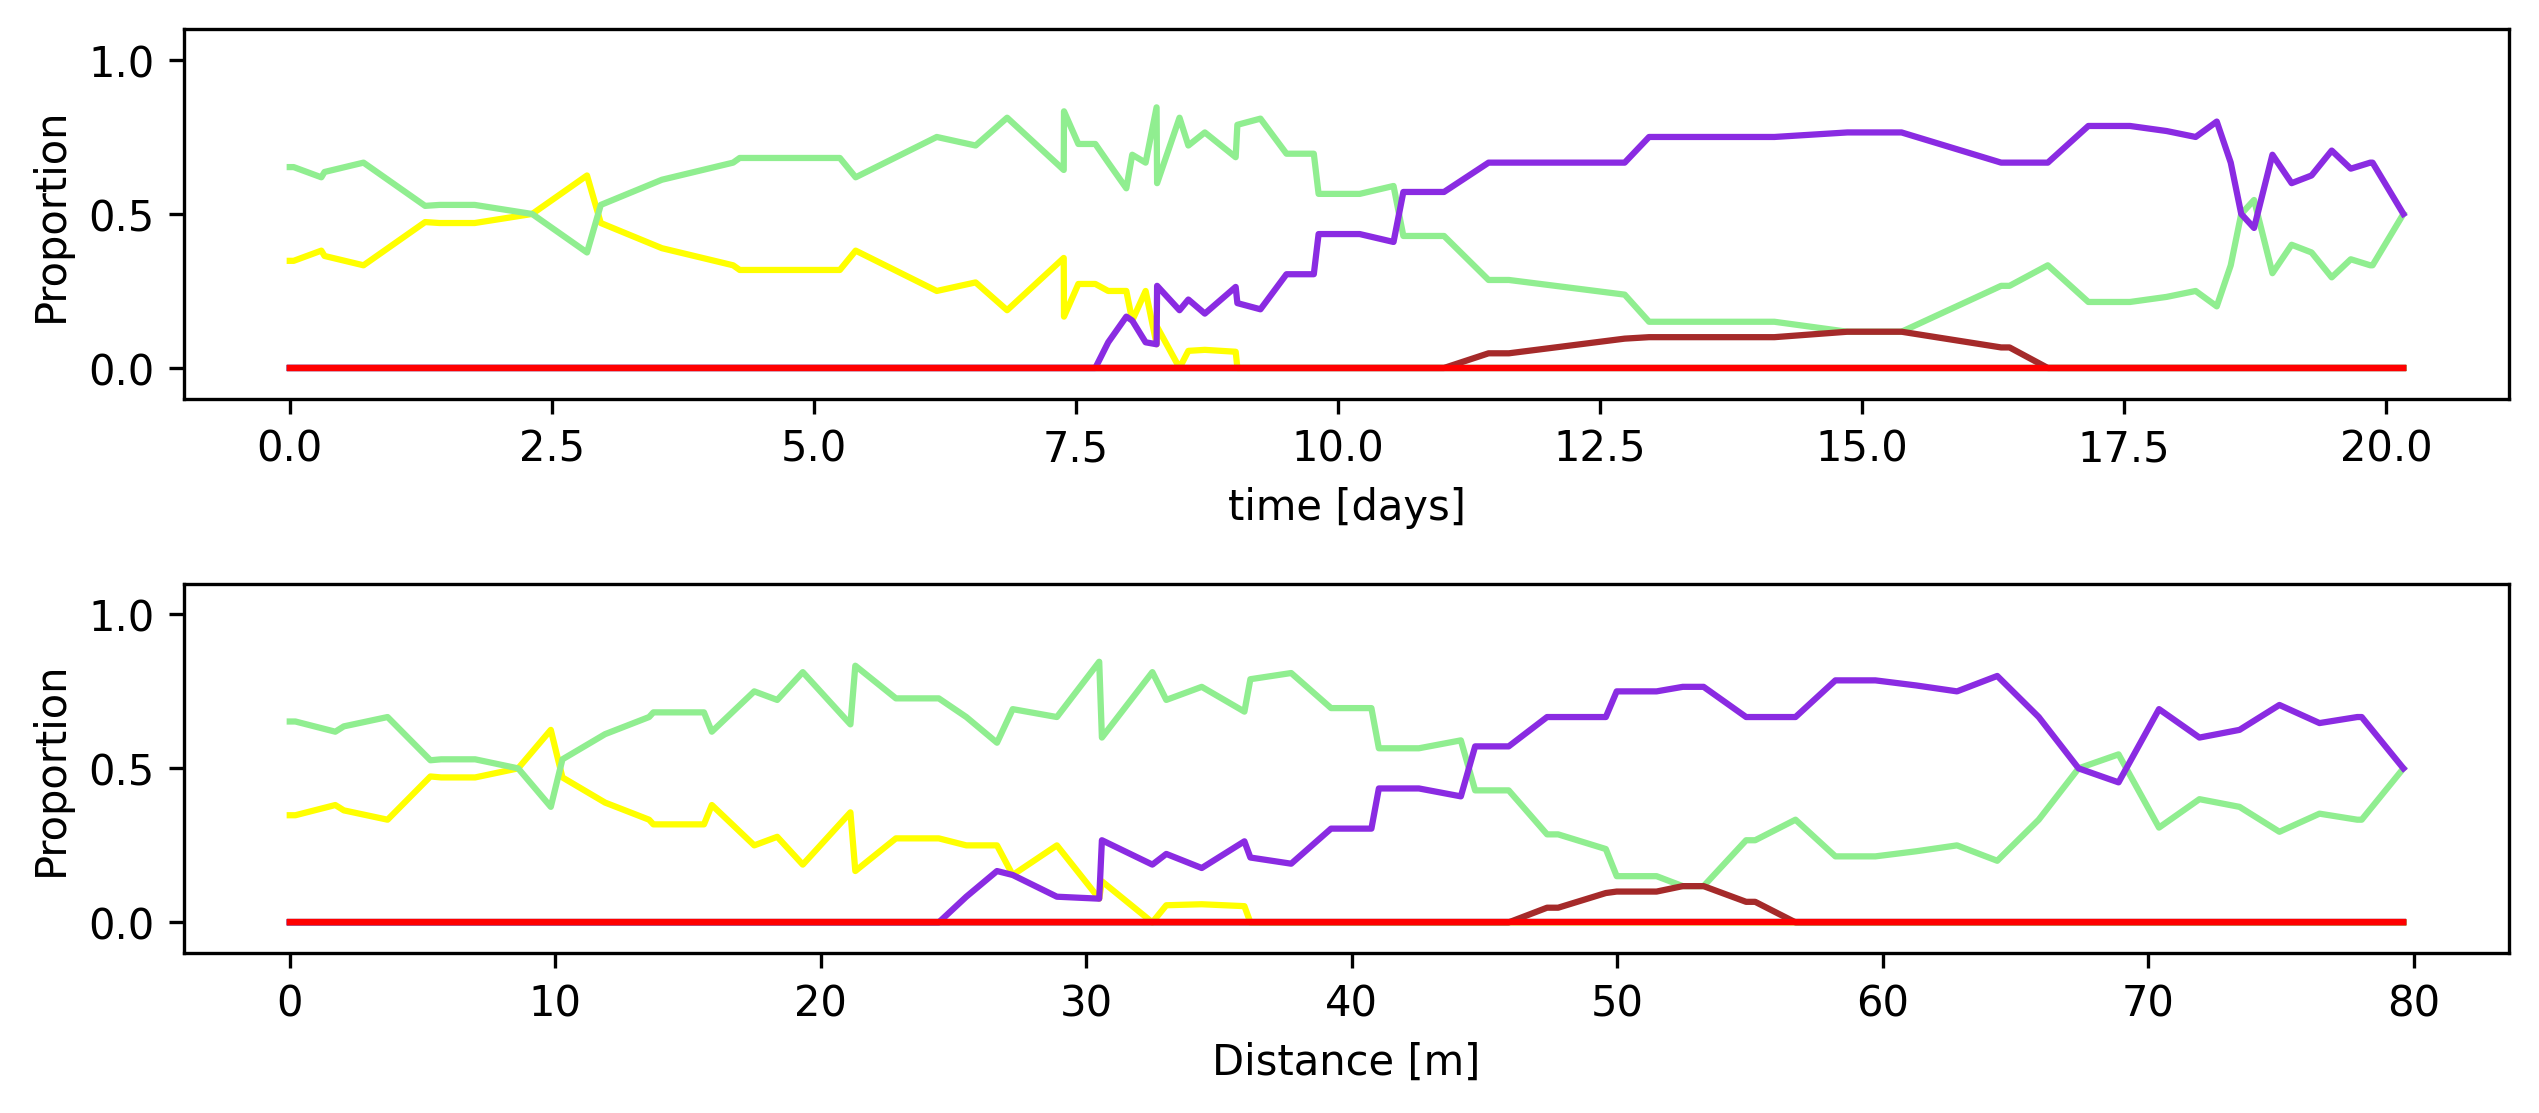

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_all.set_index("time").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_all.set_index("cum_distance").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylim(-.1, 1.1)

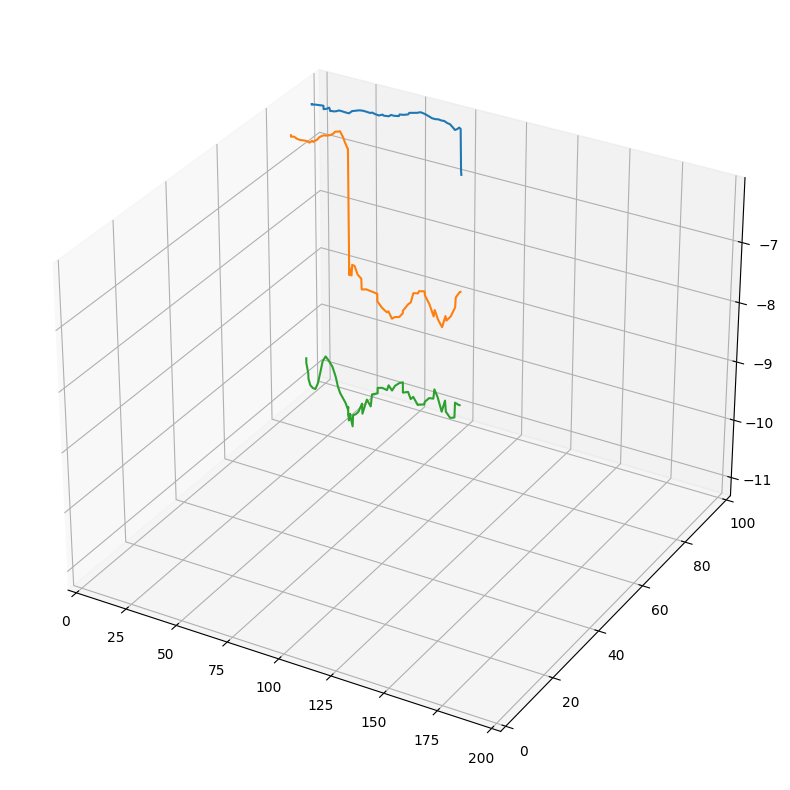

In [101]:
# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[:]:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
plt.show()

### Upscaled model

In [43]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="new_resolution", iu=0, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True,
                k_average_method="new_resolution")

Simulation created
To retrieve the simulation, use the get_sim() method


In [45]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [46]:
pv.set_jupyter_backend("static")

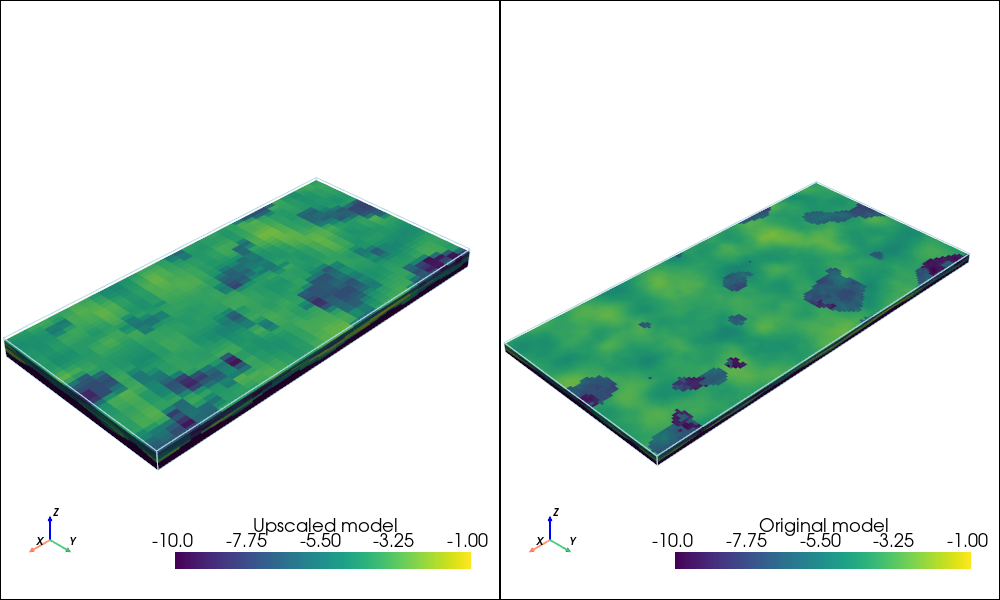

In [47]:
pl = pv.Plotter(shape=(1, 2), window_size=[1000, 600])

sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()
arr = np.log10(gwf.npf.k.array)
arr[arr==arr[0, 0, 0]] = np.nan
arr = np.flip(np.flipud(arr), axis=1)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=gwf.dis.delr[0], sy=gwf.dis.delc[0], sz=0.3, val=arr, nv=1,
                   varname=["Upscaled model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)

pl.subplot(0, 1)
arr = T1.get_prop("K", 0, 0, 0, all_data=False)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=3, sy=3, sz=0.15, nv=1,
                    val=arr.reshape(1, *arr.shape), varname=["Original model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)

pl.show()

In [48]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [79]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

(True, [])

In [50]:
mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coord=[(70.7, 99.75, -7), (70.7, 99.75, -9), (70.7, 99.75, -11)])
archpy_flow.mp_run(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\..\Switchdrive\Post_doc\prog\exe\modflow_exe\win64\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                  

In [88]:
df_pi = get_df_particle(archpy_flow, 0, fac_time=1/86400)

In [89]:
colors_fa = []
for col in df_pi.columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

(-0.1, 1.1)

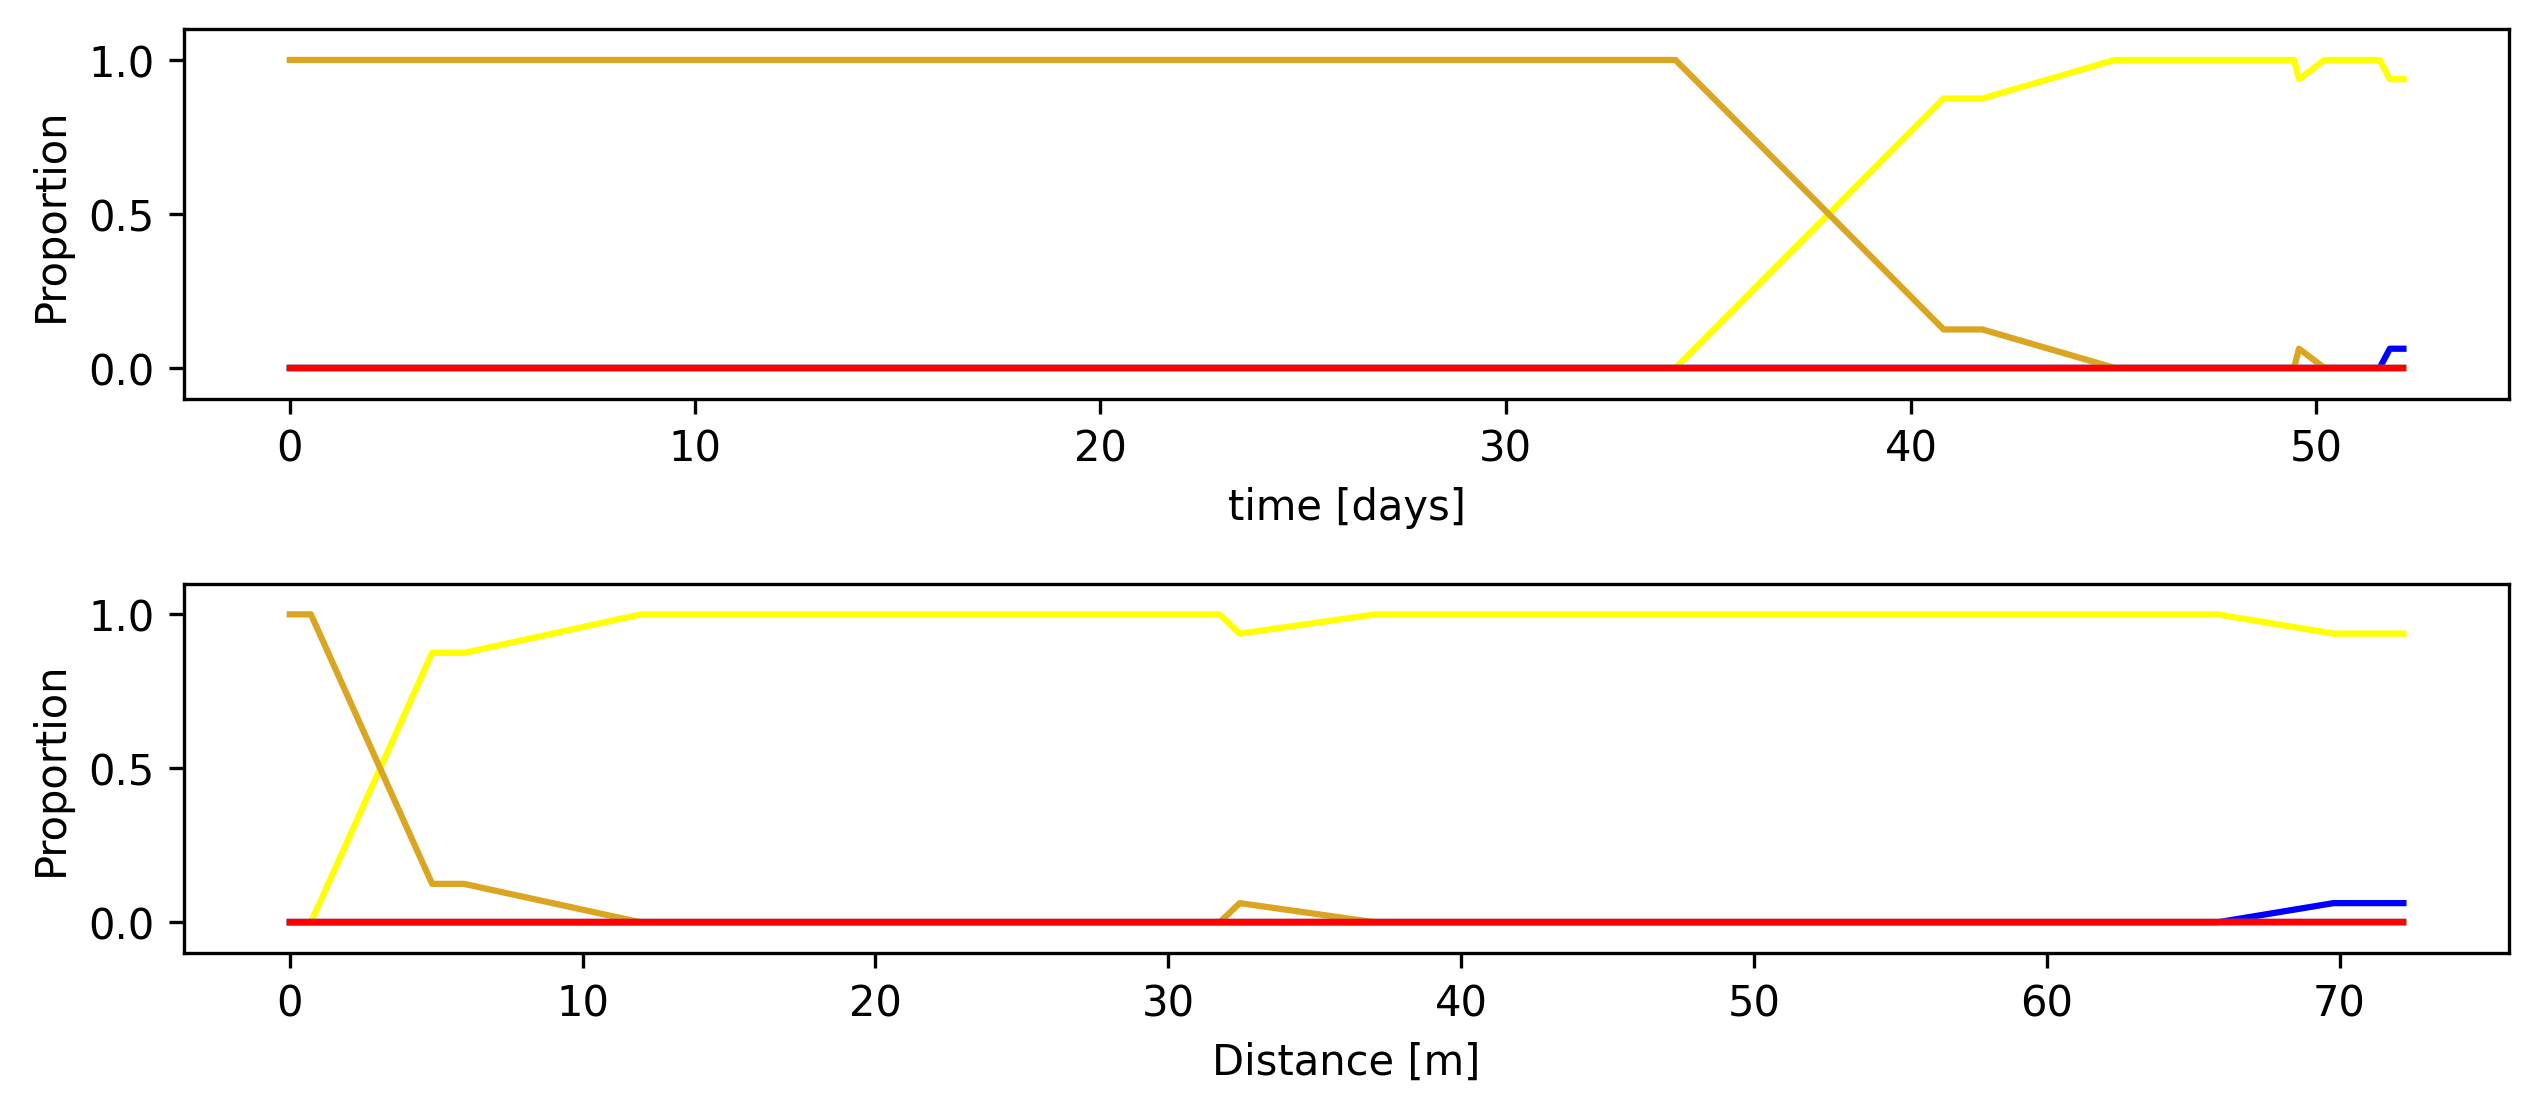

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_pi.set_index("time").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_pi.set_index("cum_distance").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]") 
ax[1].set_ylim(-.1, 1.1)

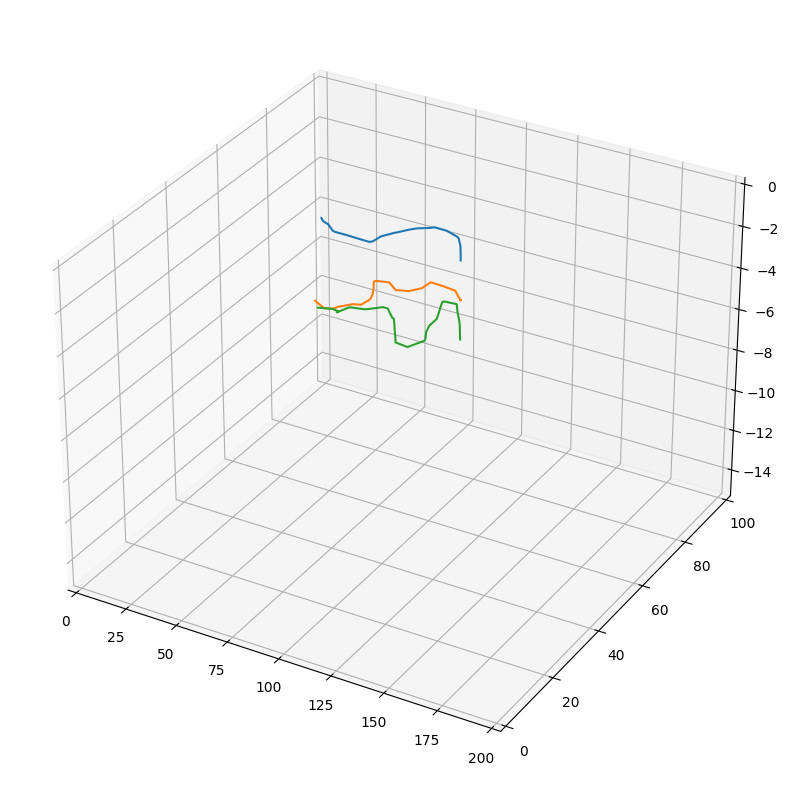

In [84]:
p = archpy_flow.mp_get_pathlines_object()
path = p.get_alldata()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[:]:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
plt.show()

how to compare pathlines using different grid mode ?

- compute distance between the two pathlines (optimal transport, minimal surface ?)
- difference between time and distance traveled
- compare facies encountered (but how ?)
- compare units encountered

## Comparisons

In [162]:
np.random.seed(1)
# compare pathlines between the 3 modes

n_loc = 10
particles_loc_x = np.random.uniform(100, T1.get_xg()[-1], n_loc)
particles_loc_y = np.random.uniform(0, T1.get_yg()[-1], n_loc)
particles_loc_z = np.random.uniform(-12, -7, n_loc)
particles_loc = list(zip(particles_loc_x, particles_loc_y, particles_loc_z))
particles_loc

[(145.87242051728313, 44.01542401234595, -7.996277156622317),
 (179.2356942786374, 71.94804754165975, -7.158692121403012),
 (100.01258122990794, 21.46748622180933, -10.432879109203785),
 (133.25658298950236, 92.20233082104927, -8.53838692165343),
 (116.14314798988244, 2.8756972857822474, -7.618054238519808),
 (110.15724542456776, 70.39908856873224, -7.526966682480763),
 (120.4886232515438, 43.81700424854833, -11.574778943151111),
 (138.01167997473524, 58.662431986803924, -11.804726083835588),
 (143.6444221653737, 14.740628552499546, -11.150847902177155),
 (159.26984074036926, 20.800656353912274, -7.609287482852935)]

In [163]:
def add_chd(archpy_flow, h1=100, h2=0):

    # add BC at left and right on all layers
    chd_data = []

    gwf = archpy_flow.get_gwf()
    
    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, 0] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h1))

    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, -1] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h2))

    chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [164]:
iu = 0
ifa = 0

# mpexe_path = "C:/Users/emmal/switchdrive2/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
# mpexe_path = "E:/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
mpexe_path = "C:/Users/Ludovic/switchdrive/Post_doc/prog/exe/modflow_exe/win64/mp7.exe"
modflow_path = "../../../../exe/mf6.exe"

# Archpy grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="archpy", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "complex"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coord=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi = []
for pi in range(n_loc):
    df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
    l_df_pi.append(df_pi)

# Layers grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="layers", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path,
                        trackdir="backward",
                        list_p_coord=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi_layers = []
for pi in range(n_loc):
    df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
    l_df_pi_layers.append(df_pi)

# New resolution grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="new_resolution", iu=iu, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k("K", iu, ifa, 0, log=True, k_average_method="new_resolution")

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path,
                        trackdir="backward",
                        list_p_coord=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi_new_res = []
for pi in range(n_loc):
    df_pi = get_df_particle(archpy_flow, pi, fac_time=1/86400)
    l_df_pi_new_res.append(df_pi)


Simulation created
To retrieve the simulation, use the get_sim() method
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 8400 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by

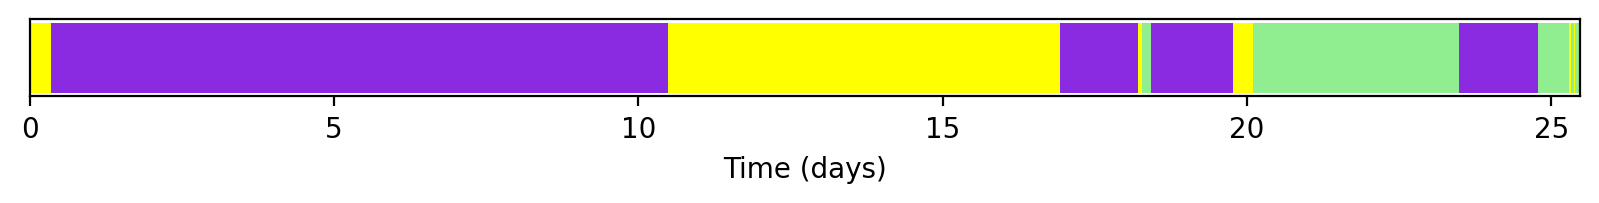

In [159]:
plot_particle_tracking(archpy_flow.T1, l_df_pi[2], plot_time=True)

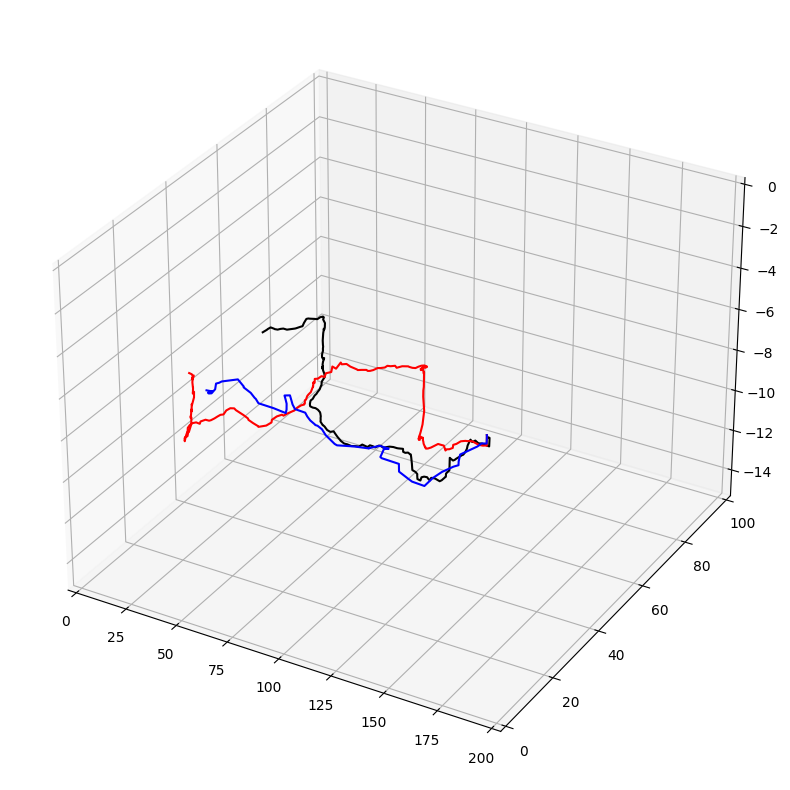

In [168]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df in l_df_pi[:1]:
    ax.plot(df["x"], df["y"], df["z"], color="k")

for df in l_df_pi_layers[:1]:
    ax.plot(df["x"], df["y"], df["z"], color="r")

for df in l_df_pi_new_res[:1]:
    ax.plot(df["x"], df["y"], df["z"], color="b")
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
plt.show()

In [143]:
l_df_pi[3]

,dt,time,distance,cum_distance,facies
0,1.157407e-07,0.000000e+00,0.000000e+00,0.000000e+00,1
1,1.157407e-07,1.157407e-07,0.000000e+00,0.000000e+00,1
2,1.157407e-07,2.314815e-07,0.000000e+00,0.000000e+00,1
3,1.157407e-07,3.472222e-07,9.536743e-07,9.536743e-07,1
4,1.157407e-07,4.629630e-07,0.000000e+00,9.536743e-07,1
...,...,...,...,...,...
161,1.614243e-04,2.121395e-01,1.570456e+00,6.295568e+01,2
162,2.258256e-03,2.123009e-01,1.361507e-01,6.309183e+01,2
163,2.261922e-03,2.145592e-01,1.571692e+00,6.466353e+01,2
164,2.133220e-03,2.168211e-01,1.523848e+00,6.618737e+01,2


In [192]:
import pandas as pd

df = pd.DataFrame(p.get_alldata()[0])

cells_path = np.array((((df["z"].values-T1.zg[0])//T1.sz).astype(int), ((df["y"].values-T1.yg[0])//T1.sy).astype(int), ((df["x"].values-T1.xg[0])//T1.sx).astype(int))).T

# keep unique cells in the path but keep the order
unique_cells = np.unique(cells_path, axis=0)
_, idx = np.unique(cells_path, axis=0, return_index=True)
unique_cells_ordered = cells_path[np.sort(idx)]
time_ordered = df["time"].values[np.sort(idx)][::-1]  # time is reversed

In [193]:
# retrieve lithologies along the pathlines
facies_domains = T1.get_facies(0, 0, all_data = False)
facies_along_path = facies_domains[unique_cells_ordered[:, 0], unique_cells_ordered[:, 1], unique_cells_ordered[:, 2]][::-1]

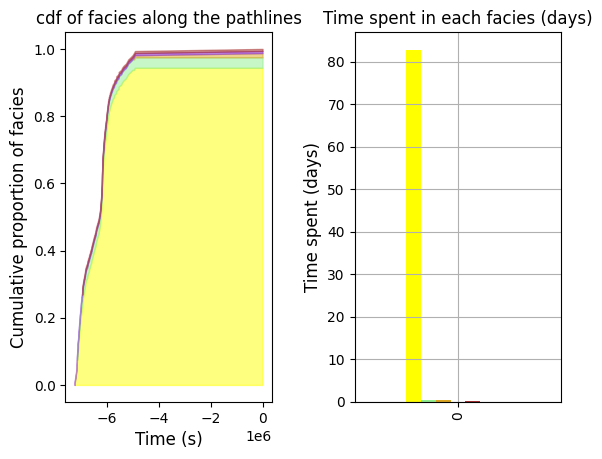

In [196]:
%matplotlib inline
# plot cumulative distribution of the facies along the pathlines vs the time
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)

curves = []

list_facies = [fa for fa in T1.get_all_facies()]
# orders facies by proportions
list_facies = sorted(list_facies, key=lambda x: -np.sum(facies_along_path == x.ID))
for fa in list_facies:
    curves.append(np.cumsum(facies_along_path == fa.ID) / len(facies_along_path))

prev_curve = np.zeros_like(curves[0], dtype=float)
for i, fa in enumerate(list_facies):
    curve = curves[i].astype(float) 
    curve[curve == 0] = np.nan
    ax[0].fill_between(-time_ordered, curve+prev_curve, prev_curve, alpha=0.5, color=fa.c)
    # ax[0].plot(-time_ordered, curve+prev_curve, label=fa.name, color=fa.c, marker="o", linewidth=0)
    prev_curve[~np.isnan(curve)] = curve[~np.isnan(curve)] + prev_curve[~np.isnan(curve)]

ax[0].set_xlabel("Time (s)", fontsize=12)
ax[0].set_ylabel("Cumulative proportion of facies", fontsize=12)
ax[0].set_title("cdf of facies along the pathlines")
# print time spent in each facies 

df_time = pd.DataFrame(columns=[fa.name for fa in list_facies])
# initialize the time spent in each facies
time_spent = np.zeros(len(list_facies))
for i, fa in enumerate(list_facies):
    time_spent[i] = np.sum(facies_along_path == fa.ID)
df_time.loc[0] = time_spent

for i in range(len(time_ordered)-1):
    dt = time_ordered[i] - time_ordered[i+1]
    for j, fa in enumerate(list_facies):
        if facies_along_path[i] == fa.ID:
            time_spent[j] += dt

df_time /= 86400  # convert seconds to days

color_facies = [fa.c for fa in list_facies]

df_time.plot(kind="bar", color=color_facies, legend=False, logy=False, ax=ax[1])
ax[1].set_title("Time spent in each facies (days)")
ax[1].set_ylabel("Time spent (days)", fontsize=12)
plt.grid()
plt.show()